# Funcion de Activacion 

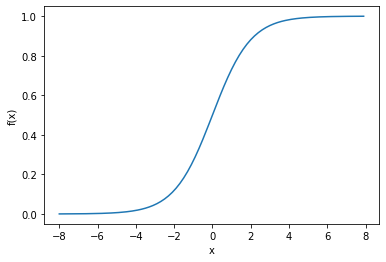

In [31]:
import matplotlib.pylab as plt
import numpy as np
x = np.arange(-8, 8, 0.1)
f = 1 / (1 + np.exp(-x))
plt.plot(x, f)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

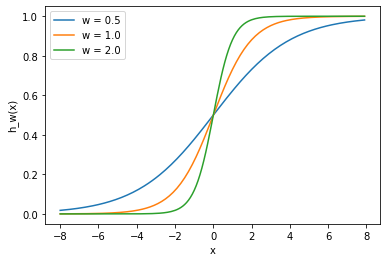

In [32]:
w1 = 0.5
w2 = 1.0
w3 = 2.0
l1 = 'w = 0.5'
l2 = 'w = 1.0'
l3 = 'w = 2.0'
for w, l in [(w1, l1), (w2, l2), (w3, l3)]:
    f = 1 / (1 + np.exp(-x*w))
    plt.plot(x, f, label=l)
plt.xlabel('x')
plt.ylabel('h_w(x)')
plt.legend(loc=2)
plt.show()

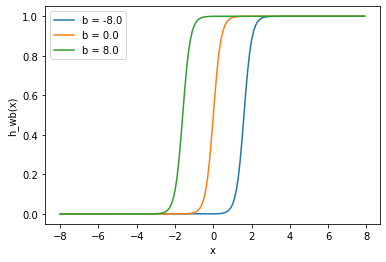

In [33]:
w = 5.0
b1 = -8.0
b2 = 0.0
b3 = 8.0
l1 = 'b = -8.0'
l2 = 'b = 0.0'
l3 = 'b = 8.0'
for b, l in [(b1, l1), (b2, l2), (b3, l3)]:
    f = 1 / (1 + np.exp(-(x*w+b)))
    plt.plot(x, f, label=l)
plt.xlabel('x')
plt.ylabel('h_wb(x)')
plt.legend(loc=2)
plt.show()

# Avance Frontal

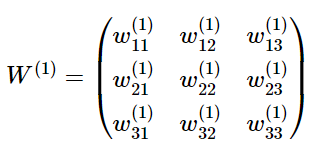

In [34]:
w1 = np.array([[0.2, 0.2, 0.2], [0.4, 0.4, 0.4], [0.6, 0.6, 0.6]])

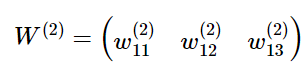

In [35]:
w2 = np.zeros((1, 3))
w2[0,:] = np.array([0.5, 0.5, 0.5])

In [36]:
b1 = np.array([0.8, 0.8, 0.8])
b2 = np.array([0.2])

In [37]:
# Definicion funcion de Activacion 
def f(x):
    return 1 / (1 + np.exp(-x))

In [38]:
# Funcion de sustitucion de valores w y by calculo de h
def simple_looped_nn_calc(n_layers, x, w, b):
    for l in range(n_layers-1):
        if l == 0:
            node_in = x
        else:
            node_in = h
        h = np.zeros((w[l].shape[0],))
        for i in range(w[l].shape[0]):
            #
            f_sum = 0
            #
            for j in range(w[l].shape[1]):
                f_sum += w[l][i][j] * node_in[j]
            #
            f_sum += b[l][i]
            #
            #
            h[i] = f(f_sum)
    return h

In [39]:
w = [w1, w2]
b = [b1, b2]
#a dummy x input vector
x = [1.5, 2.0, 3.0]

In [40]:
#Calculo total de h
h=simple_looped_nn_calc(3, x, w, b)

In [41]:
h

array([0.83545566])

In [42]:
%timeit simple_looped_nn_calc(3, x, w, b)

The slowest run took 6.25 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 19.9 µs per loop


In [43]:
def matrix_feed_forward_calc(n_layers, x, w, b):
    for l in range(n_layers-1):
        if l == 0:
            node_in = x
        else:
            node_in = h
        z = w[l].dot(node_in) + b[l]
        h = f(z)
    return h

# Gradiente decendente

In [44]:
x_old = 0 # 
x_new = 4 # 
gamma = 0.01 # 
precision = 0.00000001
cont=0
def df(x):
    y = 4 * x**3 - 9 * x**2
    return y
while abs(x_new - x_old) > precision:
    x_old = x_new
    cont=cont+1
    x_new = x_old -gamma * df(x_old)
print("El mínimo local esta en %f" % x_new)
print("Numero de iteraciones %f" % cont)

El mínimo local esta en 2.250000
Numero de iteraciones 72.000000


# Maximo descenso con backpropagation

In [45]:

import numpy as np
# Declaracion de nueva clase como Modelo
class NeuralNetwork(object):
  # iniciacion al azar de pesos(w) y bias(b)
    def __init__(self, layers = [2 , 10, 1], activations=['sigmoid', 'sigmoid']): 
        assert(len(layers) == len(activations)+1)
        self.layers = layers
        self.activations = activations
        self.weights = []
        self.biases = []
        for i in range(len(layers)-1):
            self.weights.append(np.random.randn(layers[i+1], layers[i]))
            self.biases.append(np.random.randn(layers[i+1], 1))
    
    def feedforward(self, x):
        # Calculo de frontal
        a = np.copy(x)
        z_s = []
        a_s = [a]
        for i in range(len(self.weights)):
            activation_function = self.getActivationFunction(self.activations[i])
            z_s.append(self.weights[i].dot(a) + self.biases[i])
            a = activation_function(z_s[-1])
            a_s.append(a)
        return (z_s, a_s)
# propagacion hacia atras
    def backpropagation(self,y, z_s, a_s):
        dw = []  # dC/dW
        db = []  # dC/dB
        deltas = [None] * len(self.weights)  # delta = dC/dZ  error  para cada capa
        # 
        deltas[-1] = ((y-a_s[-1])*(self.getDerivitiveActivationFunction(self.activations[-1]))(z_s[-1]))
        # ejecuta BackPropagation
        for i in reversed(range(len(deltas)-1)):
            deltas[i] = self.weights[i+1].T.dot(deltas[i+1])*(self.getDerivitiveActivationFunction(self.activations[i])(z_s[i]))        
        #
        batch_size = y.shape[1]
        db = [d.dot(np.ones((batch_size,1)))/float(batch_size) for d in deltas]
        dw = [d.dot(a_s[i].T)/float(batch_size) for i,d in enumerate(deltas)]
        # regresa las deltas respecto a la matrix pesos y bias
        return dw, db
# Entrenamiento 
    def train(self, x, y, batch_size=10, epochs=100, lr = 0.01):
        # actualiza los pesos y bias en relacion a la salida
        e_print=0
        for e in range(epochs): 
            i=0
            while(i<len(y)):
                x_batch = x[i:i+batch_size]
                y_batch = y[i:i+batch_size]
                i = i+batch_size
                z_s, a_s = self.feedforward(x_batch)
                dw, db = self.backpropagation(y_batch, z_s, a_s)
                self.weights = [w+lr*dweight for w,dweight in  zip(self.weights, dw)]
                self.biases = [w+lr*dbias for w,dbias in  zip(self.biases, db)]
                if e >= e_print:
                  e_print = e_print+int(epochs/10)
                  print("epoch = "+str(e)+", "+"error = {}".format(np.linalg.norm(a_s[-1]-y_batch) ))
    @staticmethod
    def getActivationFunction(name): #funciones de activacion 
        if(name == 'sigmoid'):
            return lambda x : np.exp(x)/(1+np.exp(x))
        elif(name == 'linear'):
            return lambda x : x
        elif(name == 'relu'):
            def relu(x):
                y = np.copy(x)
                y[y<0] = 0
                return y
            return relu
        else:
            print('Funcion de activacion desconocida')
            return lambda x: x
    
    @staticmethod
    def getDerivitiveActivationFunction(name): #Derivadas funciones de activacion
        if(name == 'sigmoid'):
            sig = lambda x : np.exp(x)/(1+np.exp(x))
            return lambda x :sig(x)*(1-sig(x)) 
        elif(name == 'linear'):
            return lambda x: 1
        elif(name == 'relu'):
            def relu_diff(x):
                y = np.copy(x)
                y[y>=0] = 1
                y[y<0] = 0
                return y
            return relu_diff
        else:
            print('Funcion de activacion desconocida')
            return lambda x: 1
 

In [50]:
X = np.array([[0., 0.],[0., 1.],[1.,0.],[1.,1.]])
y = np.array([[0,1,1,0]])
my_nn = NeuralNetwork([2,2,1],activations=['relu', 'sigmoid'])

In [51]:
my_nn.train(X.transpose(), y, epochs=100000, batch_size=4, lr = .1)

z_s, a_s = my_nn.feedforward(X.transpose())
print('Predicción:', a_s[2])
print('Salida deseada:', y)

epoch = 0, error = 1.30157339843987
epoch = 10000, error = 0.09671592107422247
epoch = 20000, error = 0.058435298831101115
epoch = 30000, error = 0.04489184944387551
epoch = 40000, error = 0.03755783194841005
epoch = 50000, error = 0.03282745590164554
epoch = 60000, error = 0.02946726556783661
epoch = 70000, error = 0.02692900283568455
epoch = 80000, error = 0.024927301177397675
epoch = 90000, error = 0.023298333459811426
Predicción: [[0.01765035 0.99207146 0.9920715  0.00664223]]
Salida deseada: [[0 1 1 0]]
